In [271]:
import numpy as np
from sklearn import preprocessing, utils
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from autoencoder import Autoencoder as Autoencoder

In [3]:
import pandas as pd
from IPython.display import display
breastcancer_data_raw = pd.read_csv(
    'datasets/breast-cancer-wisconsin.data.txt', 
    header=None, 
    names=['ID','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class'], 
    na_values=['?']
)
breastcancer_data_raw = breastcancer_data_raw.drop(['ID', 'Class'], axis=1).dropna()
display(breastcancer_data_raw.info())
variable_count = len(breastcancer_data_raw.columns)
bc_scaler = preprocessing.MinMaxScaler()
bc_scaler.fit(breastcancer_data_raw)
breastcancer_data = bc_scaler.transform(breastcancer_data_raw)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 9 columns):
Clump Thickness                683 non-null int64
Uniformity of Cell Size        683 non-null int64
Uniformity of Cell Shape       683 non-null int64
Marginal Adhesion              683 non-null int64
Single Epithelial Cell Size    683 non-null int64
Bare Nuclei                    683 non-null float64
Bland Chromatin                683 non-null int64
Normal Nucleoli                683 non-null int64
Mitoses                        683 non-null int64
dtypes: float64(1), int64(8)
memory usage: 53.4 KB


None

In [281]:
Autoencoder = imp.reload(autoencoder).Autoencoder
ae = Autoencoder([9,6,2,6,9], training_set=breastcancer_data)

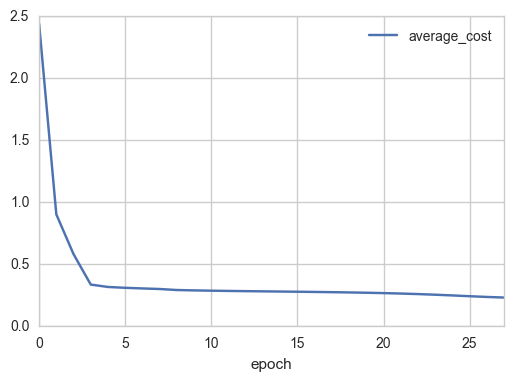

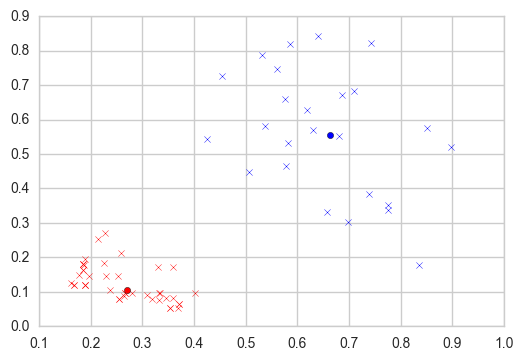

In [284]:
ae.cluster(epochs=30, learning_rate=0.1, q=0.1, k=2)
ae.plot_stats()
ae.plot_clusters()